Burgers equation is

$$
\frac{\delta u}{\delta t} + \lambda_1\frac{\delta u}{\delta x} = \lambda_2\frac{\delta^2 u}{\delta x^2}
$$
where

$$
x \in [-1,1]
$$

and 
$$
t \in [0,1]
$$

The forward problem is if we have the parameters $\lambda_1$ and $\lambda_2$ and we solve the PDE. We use PINNS to do this in a meshless way and to get data

That's all very well and good, but what about if we have the data to begin with (through obersvation) and we wanted to understand what the parameters were.  

This is known as the "inverse problem". Other ways is called "parameter estimation". 

Our referecne solution is:
    
$$
\lambda = [1,\frac{1}{100\pi}]
$$

The Over all strategy will be to train a neural network, with an added couple of parameters

$$
u_t + \lambda_1 u u_x - \lambda_2 u_{xx} \approx N_t + \lambda_1 NN_x -\lambda_2 N_xx = 0
$$

where N and G are different Nueral networks

# Libraries

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
device = 'cpu'

# Exploring the true solution

In [16]:
true_result=scipy.io.loadmat('Burgers.mat')
u_true = true_result['usol']
t = true_result['t']
x = true_result['x']

Text(0, 0.5, 'x')

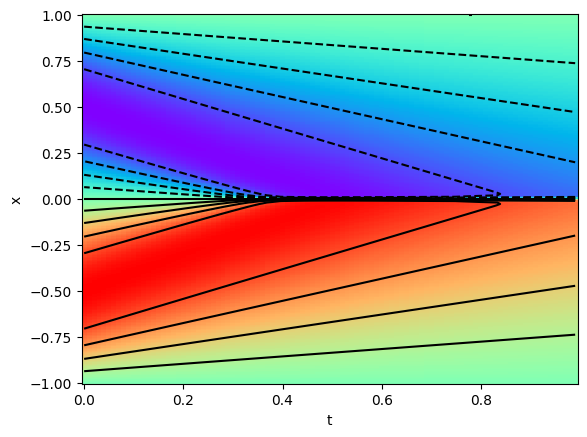

In [17]:
tt,xx = np.meshgrid(t.squeeze(),x.squeeze())
plt.pcolormesh( tt,xx, u_true,cmap='rainbow')
plt.contour(tt,xx, u_true, 10, colors='k')
plt.xlabel("t")
plt.ylabel('x')

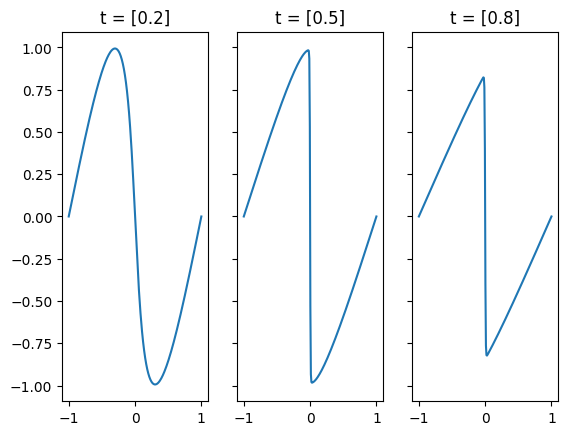

In [18]:
# Lets visualise this on a plot where time is a diffeerent line
f, ax = plt.subplots(1, 3, sharey=True)
t_index = [20,50,80]
for i in range(len(t_index)):
    ax[i].plot(x, u_true[:,t_index[i]])
    ax[i].set_title(f't = {t[t_index[i]]}')

# Training the NN

In [19]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

In [20]:
class FCN(nn.Module):
    def __init__(self,layers,l1_init = 1.0,l2_init = 0.02):
        super().__init__()
        self.layers = layers
        self.activation =nn.Tanh()
        self.loss_function = nn.MSELoss(reduction= 'mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        
        # Register two other paramters
        self.l1 = nn.Parameter(torch.tensor([l1_init], requires_grad=True).float())
        self.l2 = nn.Parameter(torch.tensor([l2_init], requires_grad=True).float())
        
        self.register_parameter("l1",self.l1)
        self.register_parameter("l2",self.l2)
    
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        return self.linears[-1](a) # This one is outside of the loop, otherwise you would be applying an activation
    
    def lossBC(self,x_bc,y_bc):
        # x is the inputs (i.e. x,t pairs)
        # y is the expected output
        loss_bc = self.loss_function(self.forward(x_bc),y_bc)
        return loss_bc
    
    def lossPDE(self,x_pde):
        g = x_pde.clone()
        g.requires_grad = True # Not sure why we need to enable grad on the data??
        f = self.forward(g)
        f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]),retain_graph = True, create_graph = True)[0] # First derivative
        f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape), create_graph=True)[0]#second derivative
        f_t = f_x_t[:,[1]]
        f_xx = f_xx_tt[:,[0]]
        f_x = f_x_t[:,[0]]
        f = f_t + self.l1*f*f_x - self.l2*f_xx
        return self.loss_function(f,f_hat)
    
    def loss(self,x_bc,y_bc,x_pde):
        return self.lossPDE(x_pde) + self.lossBC(x_bc,y_bc)
    
    def closure(self):
        
        optimizer.zero_grad()    
        loss = self.loss(X_train_Nb, Y_train_Nb, X_train_Nf)
        loss.backward()
                
        self.iter += 1
        if self.iter % 100 == 0:
            error_vec, _ = PINN.test()
            print(loss,error_vec,self.l1.detach().numpy(),self.l2.detach().numpy())
        return loss       
    
    def test(self):
        with torch.no_grad():
            u_pred = self.forward(X_test)
            error_vec = torch.linalg.norm((Y_test-u_pred),2)/torch.linalg.norm(Y_test,2)   # Relative L2 Norm of the error (Vector)
            u_pred = u_pred.cpu().detach().numpy()
            u_pred = np.reshape(u_pred,(256,100),order='F')
        return error_vec, u_pred
    

# Preparing the data

In [21]:
Nb=100 # number of boundary condition points
Ni=1000 # Number of interior points
Nf=1000 # number of collocation points
from pyDOE import lhs         #Latin Hypercube Sampling

In [22]:
# First flatten the training data (collocation points) and create a test vector
x_test = torch.hstack((torch.from_numpy(xx.transpose(1,0).flatten()[:,None]),
                       torch.from_numpy(tt.transpose(1,0).flatten()[:,None])))
y_test = torch.from_numpy(u_true.transpose(1,0).flatten()[:,None])
lb = x_test[0]
ub = x_test[-1]

In [23]:
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t

In [24]:
initial_x = xx[:,0].squeeze()[:,None]
initial_t = tt[:,0].squeeze()[:,None]
inital_u = u_true[:,0].squeeze()[:,None]

top_x = xx[0,:].squeeze()[:,None]
top_t = tt[0,:].squeeze()[:,None]
top_u = u_true[0,:].squeeze()[:,None]

bottom_x = xx[-1,:].squeeze()[:,None]
bottom_t = tt[-1,:].squeeze()[:,None]
bottom_u = u_true[-1,:].squeeze()[:,None]

interior_x = xx.flatten()[:,None]
interior_t = tt.flatten()[:,None]
interior_u = u_true.flatten()[:,None]

x_b = np.concatenate([initial_x,top_x,bottom_x],axis = 0)
t_b = np.concatenate([initial_t,top_t,bottom_t],axis = 0)
u_b = np.concatenate([inital_u,top_u,bottom_u],axis = 0)


X_train_Nb = torch.hstack((torch.from_numpy(x_b),torch.from_numpy(t_b)) )
Y_train_Nb = torch.from_numpy(u_b)

X_train_Ni = torch.hstack((torch.from_numpy(interior_x),torch.from_numpy(interior_t)) )
Y_train_Ni = torch.from_numpy(interior_u)

idx_b = np.random.choice(X_train_Nb.shape[0],Nb,replace=False)
idx_i = np.random.choice(X_train_Ni.shape[0],Ni,replace=False)


X_train_Nb = torch.vstack((X_train_Nb[idx_b],X_train_Ni[idx_i]))
Y_train_Nb = torch.vstack((Y_train_Nb[idx_b],Y_train_Ni[idx_i]))

In [25]:
X_train_Nb=X_train_Nb.float()
Y_train_Nb=Y_train_Nb.float()
X_train_Nf=X_train_Nf.float()
f_hat = torch.zeros(X_train_Nf.shape[0],1)

X_test=x_test.float() # the input dataset (complete)
Y_test=y_test.float() # the real solution 

In [26]:
# Create the model
steps=10000
lr=0.1
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = FCN(layers)
#optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

optimizer = torch.optim.LBFGS(PINN.parameters(), lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
optimizer.step(PINN.closure)

tensor(0.0943, grad_fn=<AddBackward0>) tensor(0.4415) [0.68852234] [0.00849858]
tensor(0.0390, grad_fn=<AddBackward0>) tensor(0.2946) [0.08694358] [0.00334147]
tensor(0.0296, grad_fn=<AddBackward0>) tensor(0.2574) [0.07173073] [0.0003697]
tensor(0.0272, grad_fn=<AddBackward0>) tensor(0.2473) [0.10965111] [0.00044975]
tensor(0.0241, grad_fn=<AddBackward0>) tensor(0.2278) [0.30287096] [0.00417847]
tensor(0.0212, grad_fn=<AddBackward0>) tensor(0.1992) [0.48722407] [0.00632419]
tensor(0.0165, grad_fn=<AddBackward0>) tensor(0.1846) [0.46461076] [0.00467999]
tensor(0.0140, grad_fn=<AddBackward0>) tensor(0.1721) [0.47354418] [0.00328262]
tensor(0.0118, grad_fn=<AddBackward0>) tensor(0.1469) [0.6131185] [0.00643339]
tensor(0.0104, grad_fn=<AddBackward0>) tensor(0.1421) [0.62657183] [0.00716026]
tensor(0.0093, grad_fn=<AddBackward0>) tensor(0.1383) [0.6471151] [0.00759363]
tensor(0.0084, grad_fn=<AddBackward0>) tensor(0.1288) [0.6850286] [0.00827821]
tensor(0.0072, grad_fn=<AddBackward0>) tenso

tensor(0.3858, grad_fn=<AddBackward0>)

Text(0, 0.5, 'x')

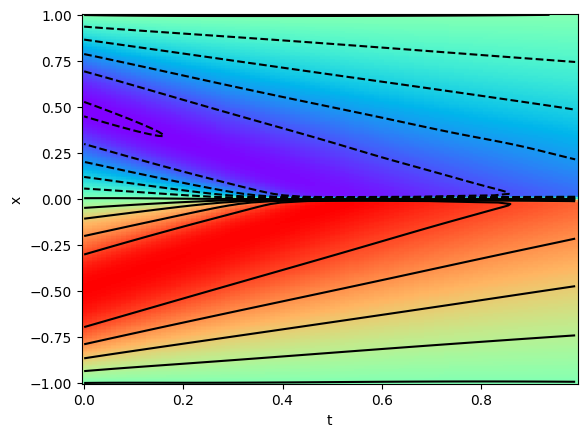

In [27]:
y1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]

arr_x1=x1.reshape(shape=[100,256]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,256]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,256]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,256]).transpose(1,0).detach().cpu()

plt.pcolormesh(arr_T1, arr_x1, arr_y1,cmap='rainbow')
plt.contour(arr_T1, arr_x1, arr_y1, 10, colors='k')
#plt.plot(X_train_Nb.detach().numpy()[:,1],X_train_Nb.detach().numpy()[:,0],'ro')
#plt.plot(X_train_Nf.detach().numpy()[:,1],X_train_Nf.detach().numpy()[:,0],'go')
plt.xlabel("t")
plt.ylabel('x')

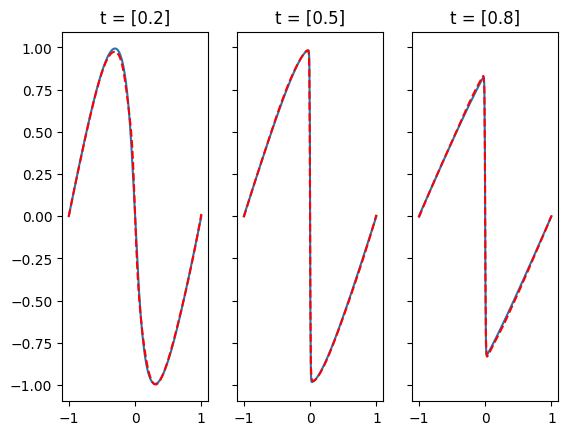

In [28]:
# Lets visualise this on a plot where time is a diffeerent line
f, ax = plt.subplots(1, 3, sharey=True)
t_index = [20,50,80]
for i in range(len(t_index)):
    ax[i].plot(x, u_true[:,t_index[i]])
    ax[i].plot(x, arr_y1[:,t_index[i]],'r--')
    ax[i].set_title(f't = {t[t_index[i]]}')